In [1]:
from triqs.gf import *
from triqs.operators import *
from triqs.operators.util.hamiltonians import h_int_kanamori, h_int_slater
from triqs.operators.util import *
from triqs.operators.util.hamiltonians import *

from h5 import HDFArchive
from triqs.atom_diag import *
import numpy as np
import sympy as sp
from itertools import product
import matplotlib.pylab as plt

In [2]:
# Definition of a 3-orbital atom
spin_names = ('up','dn')
orb_names = [0,1]
beta = 1000
target_occ = 2
U = 20
t = 1.0
mu = 10.0

uijkl = np.zeros((2,2,2,2))
uijkl[0,0,0,0] = U
uijkl[1,1,1,1] = U

tij = np.zeros((2,2))
tij[0,1] = t
tij[1,0] = t

# Set of fundamental operators
fops = [(sn,on) for sn, on in product(spin_names,orb_names)]

# Numbers of particles with spin up/down
N_up = n('up',0) + n('up',1)
N_dn = n('dn',0) + n('dn',1)
N = N_up + N_dn

# Add chemical potential
H = 0 * (N_up + N_dn)

# Add Coulomb
H += h_int_slater(spin_names, orb_names, uijkl, off_diag=True, complex=True)

# Add single partcle terms
for s, o1, o2 in product(spin_names, orb_names, orb_names):
    H += 0.5*(        tij[int(o1),int(o2)]  * c_dag(s,o1) * c(s,o2) + 
              np.conj(tij[int(o1),int(o2)]) * c_dag(s,o2) * c(s,o1))

/usr/lib/python3.10/dist-packages/triqs/operators/util/hamiltonians.py:33: UserWarning: h_int_slater takes as a second argument the number of orbitals, not a list of orbital names
  warnings.warn("{} takes as a second argument the number of orbitals, not a list of orbital names".format(fname))


In [3]:
step = 0.5
while True:

    H += mu * N
    ad = AtomDiagComplex(H, fops, n_min=target_occ-1, n_max=target_occ+1)

    beta = 1e5
    dm = atomic_density_matrix(ad, beta)
    filling = trace_rho_op(dm, N, ad)

    if abs(filling.real-target_occ) < 1.0e-4:
        break
    elif filling.real < target_occ:
        H += -mu * N
        mu+=-step
    elif filling.real > target_occ:
        H += -mu * N
        mu+=step    
    
print("mu:", mu, "filling:", filling)

mu: -1.0 filling: (1.9999999999999991+0j)


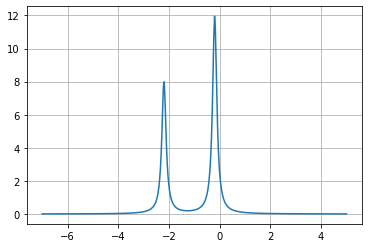

In [5]:
gf_struct = [('dn', len(orb_names)),
             ('up', len(orb_names))]

G_w = atomic_g_w(ad, beta, gf_struct, (-7, 5), 400, 0.1)

f = np.array(list(G_w['up'].mesh.values()))
plt.figure(1)
plt.clf()
plt.grid(True)
plt.plot(f, -np.imag(np.trace(G_w['up'].data[:,:,:], axis1=1, axis2=2))+
            -np.imag(np.trace(G_w['dn'].data[:,:,:], axis1=1, axis2=2)) ) 